
# 🗣️ 02 — NLP na coluna *Overview* (Inferência de Gênero)

Objetivo: Treinar um classificador que **prediz o gênero principal** de um filme usando apenas o texto da coluna **Overview**.

- Entrada: `data/movies.csv`
- Rótulo: `Genre_Primary` (primeiro gênero de `Genre`)
- Features: TF-IDF de `Overview`
- Modelos: Regressão Logística (baseline), comparação rápida e *grid search*


In [1]:

# Imports
import warnings
warnings.filterwarnings("ignore")

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score
)

from wordcloud import WordCloud

# Display
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

%matplotlib inline



## 1) Carregar dados e preparar `Genre_Primary`


In [2]:

DATA_PATH = "../data/movies.csv"

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head(3)


(999, 16)


,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"


In [3]:

def split_genre(genre):
    if pd.isna(genre):
        return []
    return [g.strip() for g in str(genre).split(",") if g.strip()]

df["Genre_List"] = df["Genre"].apply(split_genre)
df["Genre_Primary"] = df["Genre_List"].apply(lambda lst: lst[0] if lst else np.nan)

# Remover linhas sem Overview ou sem Genre_Primary
nlp_df = df.dropna(subset=["Overview", "Genre_Primary"]).copy()
nlp_df["Overview"] = nlp_df["Overview"].astype(str)
nlp_df["Genre_Primary"] = nlp_df["Genre_Primary"].astype(str)

print("Linhas com Overview & Genre_Primary:", nlp_df.shape)
nlp_df[["Series_Title","Genre","Genre_Primary","Overview"]].head(5)


Linhas com Overview & Genre_Primary: (999, 18)


,Series_Title,Genre,Genre_Primary,Overview
0,The Godfather,"Crime, Drama",Crime,An organized crime dynasty's aging patriarch t...
1,The Dark Knight,"Action, Crime, Drama",Action,When the menace known as the Joker wreaks havo...
2,The Godfather: Part II,"Crime, Drama",Crime,The early life and career of Vito Corleone in ...
3,12 Angry Men,"Crime, Drama",Crime,A jury holdout attempts to prevent a miscarria...
4,The Lord of the Rings: The Return of the King,"Action, Adventure, Drama",Action,Gandalf and Aragorn lead the World of Men agai...



## 2) Distribuição das classes (gênero principal)


,count,perc
Genre_Primary,,
Drama,288,0.288
Action,172,0.172
Comedy,155,0.155
Crime,107,0.107
Biography,88,0.088
Animation,82,0.082
Adventure,72,0.072
Mystery,12,0.012
Horror,11,0.011


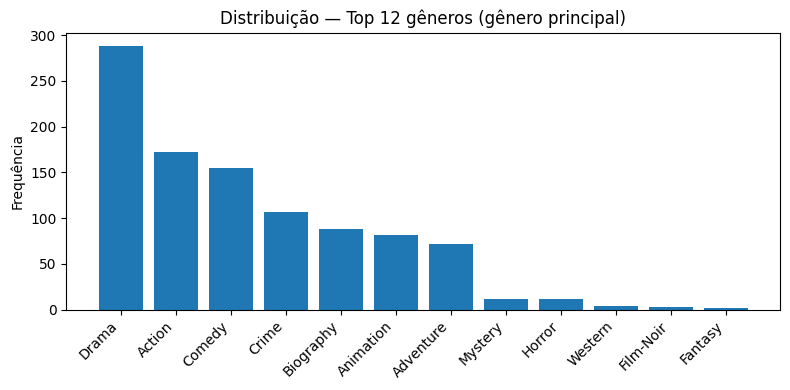

In [4]:

class_counts = nlp_df["Genre_Primary"].value_counts()
class_perc = (class_counts / class_counts.sum()).round(3)
display(pd.DataFrame({"count": class_counts, "perc": class_perc}).head(20))

fig = plt.figure(figsize=(8,4))
plt.bar(class_counts.index[:12], class_counts.values[:12])
plt.xticks(rotation=45, ha="right")
plt.title("Distribuição — Top 12 gêneros (gênero principal)")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()



## 3) *Train/test split* (estratificado)


In [6]:
# Depois de criar nlp_df com Overview e Genre_Primary:
counts = nlp_df["Genre_Primary"].value_counts()

MIN_COUNT = 3  # ajuste: 3 funciona bem com split 80/20; dá para usar 5 se o dataset permitir
nlp_df["Genre_Primary_slim"] = np.where(
    nlp_df["Genre_Primary"].map(counts) >= MIN_COUNT,
    nlp_df["Genre_Primary"],
    "Other"
)

# Conferência
counts_slim = nlp_df["Genre_Primary_slim"].value_counts()
display(counts_slim.head(20))


Genre_Primary_slim
Drama        288
Action       172
Comedy       155
Crime        107
Biography     88
Animation     82
Adventure     72
Mystery       12
Horror        11
Other          5
Western        4
Film-Noir      3
Name: count, dtype: int64

In [7]:
X = nlp_df["Overview"].astype(str)
y = nlp_df["Genre_Primary_slim"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Classes (train):")
print(y_train.value_counts())


Train: (799,)  Test: (200,)
Classes (train):
Genre_Primary_slim
Drama        230
Action       137
Comedy       124
Crime         86
Biography     70
Animation     66
Adventure     58
Mystery       10
Horror         9
Other          4
Western        3
Film-Noir      2
Name: count, dtype: int64



## 4) Baseline — TF-IDF + Regressão Logística


In [8]:

pipe = make_pipeline(
    TfidfVectorizer(stop_words="english", max_features=8000, ngram_range=(1,2)),
    LogisticRegression(max_iter=300, n_jobs=None)
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")
print(f"Accuracy: {acc:.3f}  |  F1-macro: {f1m:.3f}")
print()
print(classification_report(y_test, y_pred))


Accuracy: 0.320  |  F1-macro: 0.066

              precision    recall  f1-score   support

      Action       0.60      0.17      0.27        35
   Adventure       0.00      0.00      0.00        14
   Animation       0.00      0.00      0.00        16
   Biography       0.00      0.00      0.00        18
      Comedy       0.50      0.03      0.06        31
       Crime       0.00      0.00      0.00        21
       Drama       0.30      0.98      0.47        58
   Film-Noir       0.00      0.00      0.00         1
      Horror       0.00      0.00      0.00         2
     Mystery       0.00      0.00      0.00         2
       Other       0.00      0.00      0.00         1
     Western       0.00      0.00      0.00         1

    accuracy                           0.32       200
   macro avg       0.12      0.10      0.07       200
weighted avg       0.27      0.32      0.19       200




## 5) Matriz de confusão


<Figure size 800x600 with 0 Axes>

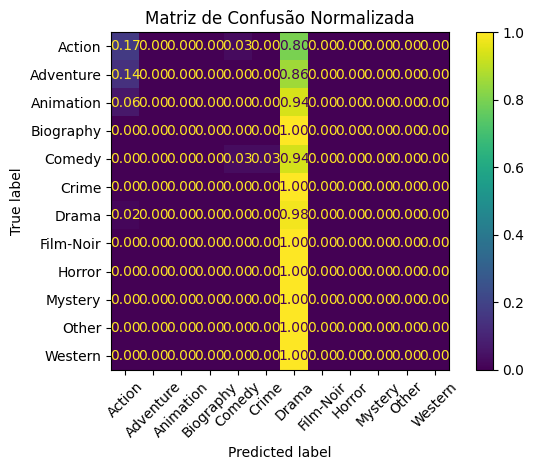

In [9]:

labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels, normalize="true")
fig = plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format=".2f", xticks_rotation=45)
plt.title("Matriz de Confusão Normalizada")
plt.tight_layout()
plt.show()



## 6) *Cross-validation* (medir robustez do baseline)


In [10]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_acc = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")
scores_f1m = cross_val_score(pipe, X, y, cv=cv, scoring="f1_macro")

print("CV Accuracy:", np.round(scores_acc, 3), " | mean:", scores_acc.mean().round(3))
print("CV F1-macro:", np.round(scores_f1m, 3), " | mean:", scores_f1m.mean().round(3))


CV Accuracy: [0.325 0.315 0.33  0.335 0.322]  | mean: 0.325
CV F1-macro: [0.083 0.076 0.085 0.076 0.095]  | mean: 0.083



## 7) *Grid search* rápido (opcional)
Ajuste fino de `max_features`, `ngram_range` e `C` da regressão logística.


In [13]:

param_grid = {
    "tfidfvectorizer__max_features": [5000, 10000],
    "tfidfvectorizer__ngram_range": [(1,1), (1,2)],
    "logisticregression__C": [0.5, 1.0, 2.0]
}

gs = GridSearchCV(pipe, param_grid, cv=3, scoring="f1_macro", n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("Best CV f1_macro:", gs.best_score_.round(3))

best = gs.best_estimator_
acc = accuracy_score(y_test, yp)
f1m = f1_score(y_test, yp, average="macro")

print(f"Test Accuracy: {acc:.3f}")
print(f"Test F1-macro: {f1m:.3f}")



Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'logisticregression__C': 2.0, 'tfidfvectorizer__max_features': 5000, 'tfidfvectorizer__ngram_range': (1, 1)}
Best CV f1_macro: 0.11
Test Accuracy: 0.375
Test F1-macro: 0.123



## 8) WordClouds por gênero (insights qualitativos)
Gera nuvem de palavras para os **Top-N** gêneros com mais amostras.


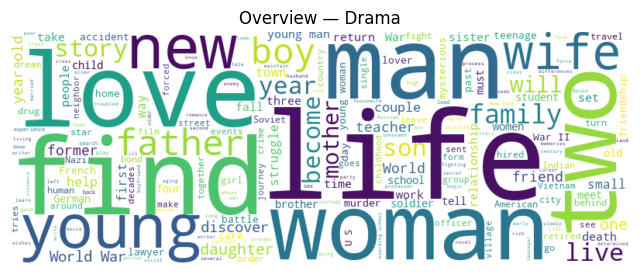

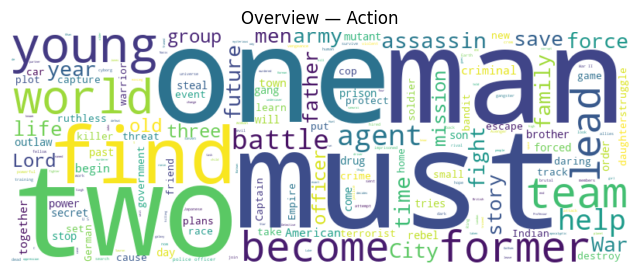

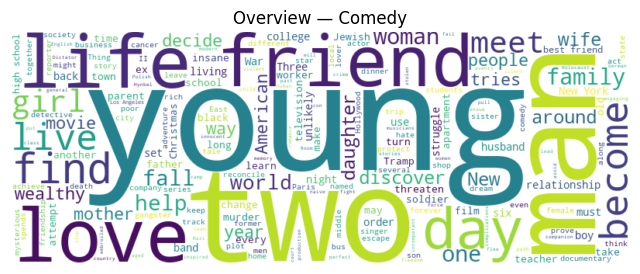

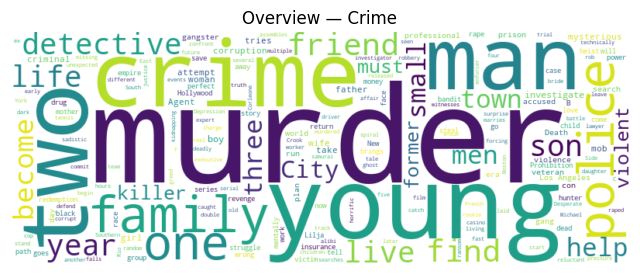

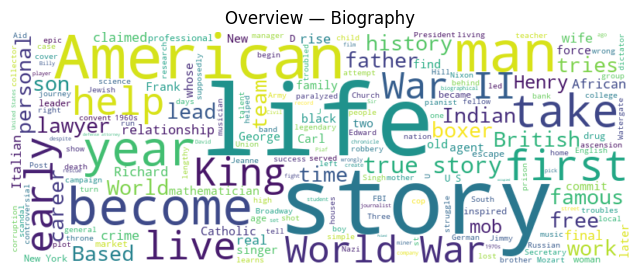

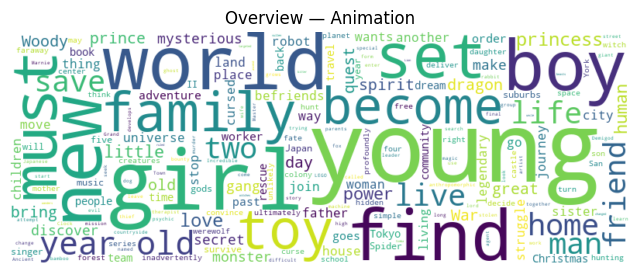

In [14]:

def make_wordcloud(text, title="WordCloud"):
    fig = plt.figure(figsize=(8,4))
    wc = WordCloud(width=800, height=300, background_color="white").generate(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

topN = 6
top_genres = nlp_df["Genre_Primary"].value_counts().head(topN).index.tolist()

for g in top_genres:
    text = " ".join(nlp_df.loc[nlp_df["Genre_Primary"]==g, "Overview"].astype(str).tolist())
    if len(text) > 0:
        make_wordcloud(text, title=f"Overview — {g}")



## 9) Salvar pipeline treinado (opcional)
Salva o **vetorizador + classificador** para uso posterior.


In [15]:

import os, pickle
os.makedirs("models", exist_ok=True)
with open("models/genre_from_overview.pkl", "wb") as f:
    pickle.dump(best if 'best' in globals() else pipe, f)
print("Modelo de gênero salvo em models/genre_from_overview.pkl")


Modelo de gênero salvo em models/genre_from_overview.pkl



## 10) Inferência com um exemplo


In [16]:

sample_overview = (
    "Two imprisoned men bond over a number of years, finding solace and eventual redemption "
    "through acts of common decency."
)
clf = best if 'best' in globals() else pipe
pred_genre = clf.predict([sample_overview])[0]
print("Gênero previsto:", pred_genre)


Gênero previsto: Drama
